In [67]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [182]:
### Psuedo Code

# sketch out journey
# Create array with number of rows that you want to simulate
# create dataframe from the array
# define distributions for journey segments
# add columns to apply the functions the simulate each segment 
# add column to pick next bus
# add column to pick next train
# Calculate total journey time
# add columns for alternate walking journey
# Calculate total journey time for alternate method
# compare two journey types

In [164]:
# Create array with number of rows that you want to simulate
# create dataframe from the array

def create_journey_dataframe(journeys=1000):
    rows = np.arange(journeys)
    df = pd.DataFrame(rows)
    df.columns = ['journey']
    return df



In [177]:
# define distributions for journey segments
journeys=10000
leave_mean, leave_stdev = 0, 5

# main journey
walk_to_bus_mean, walk_to_bus_stdev = 2, 0.5
bus_arrival_mean, bus_arrival_stdev = 1, 5
# bus_journey_mean, bus_journey_stdev = 3, 1
bus_trip_lengths = [4, 5, 6, 7, 8, 15]
bus_trip_p = [.05, .15, .25, .25, .2, .10]

# bus_journey
train_arrival_mean, train_arrival_stdev = 0, 3
train_journey_mean, train_journey_stdev = 20, 3

# alternate journey
walk_to_station_mean, walk_to_station_stdev = 16, 1
train_arrival_mean, train_arrival_stdev = 0, 3
train_journey_mean, train_journey_stdev = 20, 3



In [167]:
# Leave time gen function
def sim_leave_time(leave_time=0):
    return (leave_time + np.random.normal(leave_mean, leave_stdev, size = journeys))

In [7]:
# walk time gen function
def sim_walk_to_bus_time():
    return np.random.normal(walk_to_bus_mean, walk_to_bus_stdev, size = journeys)

In [9]:
# Bus arrive gen function
def sim_bus_arrive_time(scheduled=0):
    return (scheduled + np.random.normal(bus_arrival_mean, bus_arrival_stdev))

In [64]:
# Bus journey Time function
bus_trip_lengths = [4, 5, 6, 7, 8, 15]
bus_trip_p = [.05, .15, .25, .25, .2, .10]
def sim_bus_journey_time():
    return np.random.choice(bus_trip_lengths, size = journeys, p=bus_trip_p)

In [11]:
# Train Arrive Time function
def sim_train_arrive_time(scheduled=0):
    return scheduled + np.random.normal(train_arrival_mean, train_arrival_stdev)

In [12]:
# Train Journey Time function
def sim_train_journey_time():
    return np.random.normal(train_journey_mean, train_journey_stdev, size = journeys)

In [95]:
# function that is similar to the vlookup tool in excel. Finds closest match to value in sorted list
def find_neighbours(value, df, colname):
    exactmatch = df[df[colname] == value]
    if not exactmatch.empty:
        return exactmatch.index
    else:
        upperneighbour_ind = df[df[colname] > value][colname].idxmin()
        return upperneighbour_ind

def bus_arrivals_df(value):
    bus_schedules = list()
    for schedule in range(-60, 60, 15):
        bus_dict = {'schedule': schedule, 'arrival_time': sim_bus_arrive_time(schedule)}
        bus_schedules.append(bus_dict)
    bus_df = pd.DataFrame(bus_schedules)
    bus_df.sort_values(by='arrival_time', inplace=True)
    next_arrival_time = bus_df.iloc[find_neighbours(value, bus_df, 'arrival_time'),1]
    return next_arrival_time

def train_arrivals_df(value):
    train_schedules = list()
    for schedule in range(-60, 120, 30):
        train_dict = {'schedule': schedule, 'arrival_time': sim_train_arrive_time(schedule)}
        train_schedules.append(train_dict)
    train_df = pd.DataFrame(train_schedules)
    train_df.sort_values(by='arrival_time', inplace=True)
    next_arrival_time = train_df.iloc[find_neighbours(value, train_df, 'arrival_time'),1]
    return next_arrival_time


In [13]:
# walk to station time gen function for alternate method
def sim_walk_to_station_time():
    return np.random.normal(walk_to_station_mean, walk_to_station_stdev, size = journeys)

In [106]:
# Run simulation
def simulate_journeys(journeys):
    df = create_journey_dataframe(journeys)

    # add columns to apply the gen functions
    df['leave_time'] = sim_leave_time()

    df['walk_to_bus_time'] = sim_walk_to_bus_time()
    df['arrive_at_bus_stop'] = df['leave_time'] + df['walk_to_bus_time']

    # add column to pick next bus
    df['bus_arrive_time'] = df['arrive_at_bus_stop'].apply(lambda x: bus_arrivals_df(x))
    df['bus_journey_time'] = sim_bus_journey_time()
    df['arrive_at_train_station'] = df['bus_arrive_time'] + df['bus_journey_time']

    # add column to pick next train
    df['train_arrive_time'] = df['arrive_at_train_station'].apply(lambda x: train_arrivals_df(x))
    df['train_journey_time'] = sim_train_journey_time()

    df['arrive_at_work'] = df['train_arrive_time'] + df['train_journey_time']
    df['journey_length'] = df['arrive_at_work'] - df['leave_time']
    
    # Alternate method
    df['WM_walk_to_station_time_'] = sim_walk_to_station_time()
    df['WM_arrive_at_train_station'] = df['leave_time'] + df['WM_walk_to_station_time_']
    df['WM_train_arrive_time'] = df['WM_arrive_at_train_station'].apply(lambda x: train_arrivals_df(x))
    df['WM_train_journey_time'] = sim_train_journey_time()
    df['WM_arrive_at_work'] = df['WM_train_arrive_time'] + df['WM_train_journey_time']
    df['WM_journey_length'] = df['WM_arrive_at_work'] - df['leave_time']

    # compare two journey types
    df['walking_better'] = df['WM_arrive_at_work'] <= df['arrive_at_work']
    return df


In [178]:
df = simulate_journeys(journeys)
df.round()

,journey,leave_time,walk_to_bus_time,arrive_at_bus_stop,bus_arrive_time,bus_journey_time,arrive_at_train_station,train_arrive_time,train_journey_time,arrive_at_work,journey_length,WM_walk_to_station_time_,WM_arrive_at_train_station,WM_train_arrive_time,WM_train_journey_time,WM_arrive_at_work,WM_journey_length,walking_better
0,0,6.0,1.0,7.0,10.0,7,17.0,28.0,21.0,49.0,43.0,17.0,23.0,34.0,22.0,56.0,50.0,False
1,1,-8.0,2.0,-6.0,13.0,4,17.0,30.0,24.0,54.0,61.0,16.0,9.0,28.0,12.0,40.0,48.0,True
2,2,-7.0,1.0,-6.0,0.0,7,7.0,26.0,18.0,44.0,51.0,16.0,9.0,29.0,21.0,51.0,58.0,False
3,3,-8.0,2.0,-6.0,5.0,15,20.0,33.0,24.0,57.0,65.0,18.0,10.0,30.0,18.0,48.0,56.0,True
4,4,7.0,2.0,9.0,21.0,6,27.0,33.0,21.0,53.0,47.0,17.0,24.0,26.0,24.0,50.0,43.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,-1.0,2.0,1.0,15.0,8,23.0,25.0,19.0,44.0,45.0,16.0,15.0,28.0,19.0,47.0,48.0,False
9996,9996,0.0,2.0,2.0,12.0,6,18.0,31.0,22.0,53.0,52.0,15.0,15.0,33.0,19.0,52.0,52.0,True
9997,9997,-2.0,2.0,0.0,6.0,5,11.0,27.0,23.0,50.0,52.0,15.0,13.0,29.0,17.0,46.0,48.0,True
9998,9998,-0.0,2.0,2.0,7.0,5,12.0,30.0,21.0,51.0,51.0,16.0,16.0,26.0,22.0,48.0,48.0,True


In [179]:
sum(df['walking_better'])

5557

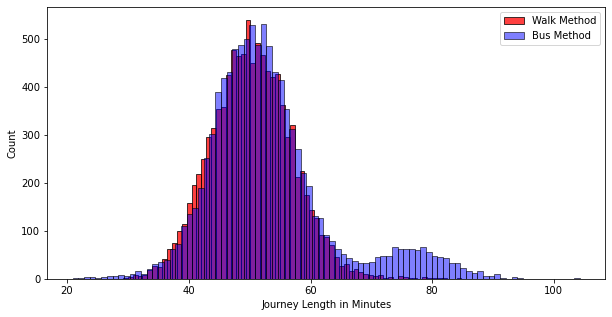

In [180]:
fig, ax = plt.subplots(figsize=(10,5))

#xmax = 120 
bins = 75 #
sns.histplot(ax = ax,
             data = df,
             x = 'WM_journey_length',
             # bins = bins,
             kde = False, 
             color = 'r')

sns.histplot(ax = ax, 
             data = df, 
             x = 'journey_length', 
             # bins = bins,
             kde = False, 
             color = 'b', 
             alpha = 0.5); # Setting the alpha creates transparency

ax.set_xlabel('Journey Length in Minutes')
ax.legend(['Walk Method', 'Bus Method']);